## Create Custom Dataset

In [18]:
!pip install SoundFile

In [1]:
# Custom Pytorch dataset
# Class Dataset, Dataloader
# Dataset stores all information regarding dataset (samples, annotations ...)
# Dataloader is an iterator wrapper around dataset, that allows to load different samples in real time

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchaudio
import os

# Constants:

ANNOTATIONS_FILE = "data/UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_DIR = "data/UrbanSound8K/audio"

# Deciding number of samples that we want to have in our dataset.
# We will use 22050 samples, which is 1 second of audio.
SAMPLE_RATE = 22050 
NUM_SAMPLES = 22050

# Check if GPU is available, else use cpu
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#Our UrbanSoundDataset class inherits from the base Dataset class
class UrbanSoundDataset(Dataset):
    
    def __init__(self, 
                 annotations_file,
                 audio_dir, 
                 transformation, 
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        # computing device in use
        self.device = device
        # Attributes for transformation of audio signal for features like Mel Spectrogram.
        # assignt the task to the computing device (cuda)
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        
    # Len is method we use to define how we use the len syntax.
    # len(usd) will return the length of the dataset (number of samples).
    def __len__(self):
        return len(self.annotations)
    
    # getitem is a method we use to define how to get a sample from the dataset.
    # work like : a_list[1] -> a_list.__getitem__(1)
    # we want to define functions, that will specify, how to get data from dataset.
    def __getitem__(self, index):
        # Loading waveform of audio sample associated with certain inddex and also the label
        # Path to the sample:
        # self._get_audio_sample - private methods
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        # Loads particular audio file from dataset class using torch audio.
        # signal -> (num_channels, samples) -> (2, 16000) -> (1, 16000)
        signal, sr = torchaudio.load(audio_sample_path)
        # When using CUDA !! Register the signal to the device (.to(self.device)) also the resampler object needs to be registered to the device.):
        signal = signal.to(self.device)
        # Resample the signal to the target sample rate, so all audio clips will have same sample rate.
        signal = self._resample_if_necessary(signal, sr)
        # Mix the signal down to mono, if it is not already.
        signal = self._mix_down_if_necessary(signal)
        # Before transformation, the signal should have number of samples = num_samples
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        # Call our mel_spectrogram transformation object on the signal to extract mel spectrograms.
        signal = self.transformation(signal)
        return signal, label
    
    # signal -> Tensor -> (1, num_samples)
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            # If the condition above is true (i.e., the signal has more samples than allowed), this line trims signal down to have exactly NUM_SAMPLES samples. It does this by keeping all channels (indicated by the first colon :) but only keeping the first NUM_SAMPLES samples along the second dimension (indicated by :NUM_SAMPLES).
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            # If the condition above is true (i.e., the signal has fewer samples than allowed), this line pads the signal with zeros along the second dimension (indicated by the second colon :) until it has exactly NUM_SAMPLES samples.
            num_missing_samples = self.num_samples - length_signal
            # number of items we want to prepend, number of items we want to append to the tensor. -> padding only along the second (last) dimension.
            last_dim_padding = (0, num_missing_samples)
            # Pad the signal with zeros along the second dimension.
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            # When using CUDA !! Register the resampler to the device (.to(self.device)) also the loaded audio signal needs to be registered to the device.):
            resampler = resampler.to(self.device)
            signal = resampler(signal)
        return signal
    
    # mean operation mix down averages the channels into a mono (single-channel).
    # The dim=0 argument tells PyTorch to compute the mean along the channel dimension, and keepdim=True ensures that the result still has two dimensions (i.e., (1, 16000) instead of (16000,)).
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1: # (2, 16000) -> (1, 16000)
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[index, 0])
        return path
        
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]
        

### Extracting Mel Spectrograms with Torchaudio
### Preprocess audio signal length

There are 8732 samples in the dataset.
Feature batch shape: torch.Size([50, 1, 64, 44])
Labels batch shape: torch.Size([50])


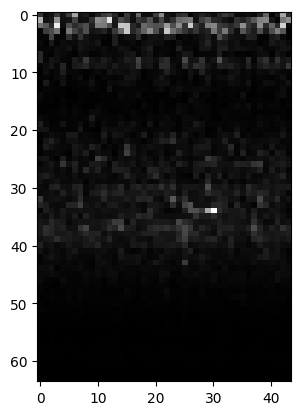

In [72]:
if __name__ == "__main__":    
    # Torchaudio.transforms - transformations for audio data like MFCCs, MelSpectrogram, AmplitudeToDB, MuLawEncoding, Resample, Spectrogram, etc.
    # MelSpectrogram - Torchaudio transformation that takes in a raw audio signal and outputs the mel spectrogram.
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    # ms = mel_spectrogram(signal)
    
    # Create instance of our UrbanSoundDataset class
    usd = UrbanSoundDataset(ANNOTATIONS_FILE, 
                            AUDIO_DIR, 
                            mel_spectrogram, 
                            SAMPLE_RATE, 
                            NUM_SAMPLES,
                            device)
    print(f"There are {len(usd)} samples in the dataset.")
    # Get the 0th sample
    signal, label = usd[0]

    
    train_dataloader = DataLoader(usd, batch_size=50)
    import matplotlib.pyplot as plt
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[30].squeeze().to("cpu")
    label = train_labels[30].to("cpu")
    plt.imshow(img, cmap="gray")
    plt.show()